In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lightweight_clustered_energy_forecasts.utils.paths import data_dir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

## Funciones auxiliares

In [3]:
def smape(y_true, y_pred):
  numerator = np.abs(y_true - y_pred)
  denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
  ratio = numerator / denominator
  return ratio.mean()


## Forcasting

In [4]:
building_11a=pd.read_csv(data_dir("interim","11a_clean.csv"),parse_dates=["timestamp"],index_col="timestamp")

In [5]:
building_11a.index.freq="15T"

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_25056\161432725.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  building_11a.index.freq="15T"


In [6]:
building_11a.head()

,kwh
timestamp,
2023-01-01 00:00:00+00:00,15.66
2023-01-01 00:15:00+00:00,15.39
2023-01-01 00:30:00+00:00,12.59
2023-01-01 00:45:00+00:00,11.26
2023-01-01 01:00:00+00:00,16.10


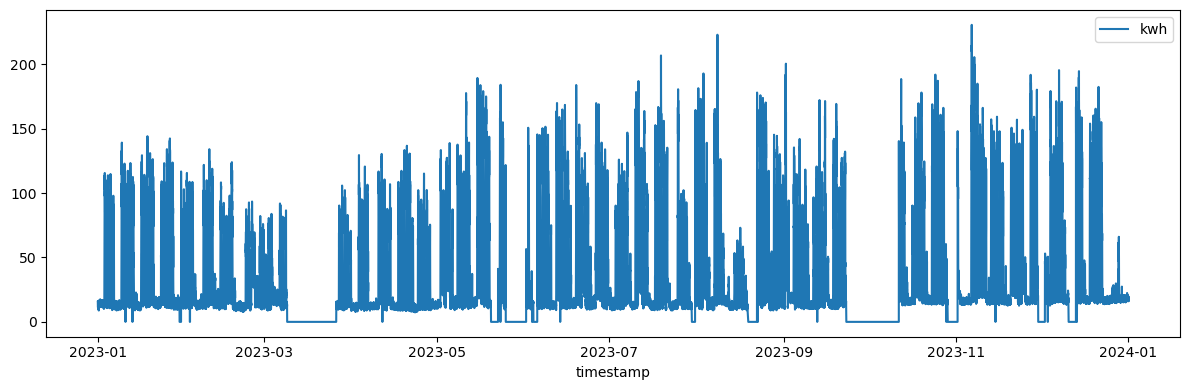

In [7]:
# Configura el tamaño de la figura antes de trazar
plt.figure(figsize=(12, 4))

# Trazar la línea usando sns.lineplot
sns.lineplot(data=building_11a)

# Ajustar el diseño para evitar que los elementos se solapen
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [8]:
building_11a_hourly=building_11a.resample("h").sum()

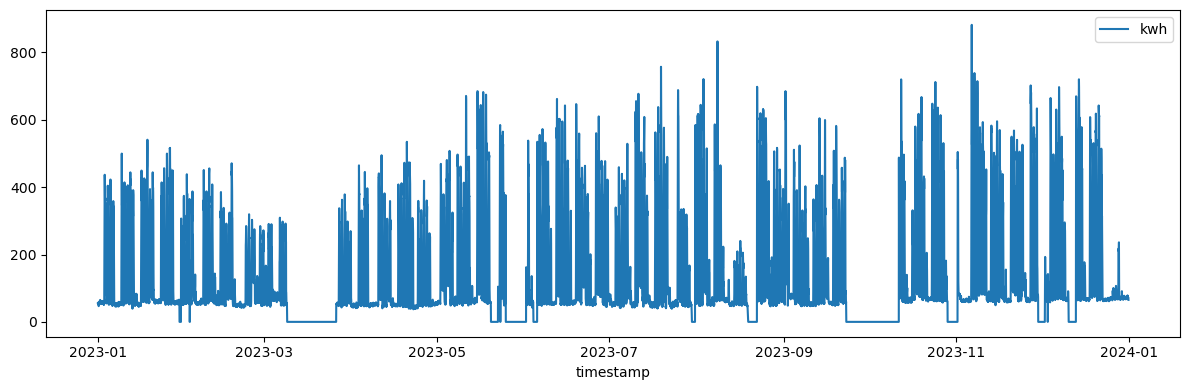

In [9]:
# Configura el tamaño de la figura antes de trazar
plt.figure(figsize=(12, 4))

# Trazar la línea usando sns.lineplot
sns.lineplot(data=building_11a_hourly)

# Ajustar el diseño para evitar que los elementos se solapen
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Prueba de estacionaridad

In [10]:
from statsmodels.tsa.stattools import adfuller

# Prueba de estacionariedad usando ADF (Dickey-Fuller Aumentada)
adf_result = adfuller(building_11a_hourly['kwh'].dropna())

# Extraer resultados de la prueba ADF
adf_output = {
    'ADF Statistic': adf_result[0],
    'p-value': adf_result[1],
    'Critical Values': adf_result[4]
}
adf_output


{'ADF Statistic': np.float64(-9.335331891551863),
 'p-value': np.float64(9.095262429715038e-16),
 'Critical Values': {'1%': np.float64(-3.431099968539641),
  '5%': np.float64(-2.86187143613454),
  '10%': np.float64(-2.5669464184887825)}}

Como el p-valor es mucho menor a 0.05 y el estadístico ADF (-9.33) es menor que los valores críticos en todos los niveles de significancia, podemos rechazar la hipótesis nula de no estacionariedad.
Esto indica que la serie temporal ya es estacionaria en su forma actual y no necesita diferenciación adicional.

## Análisis ACF y PACF

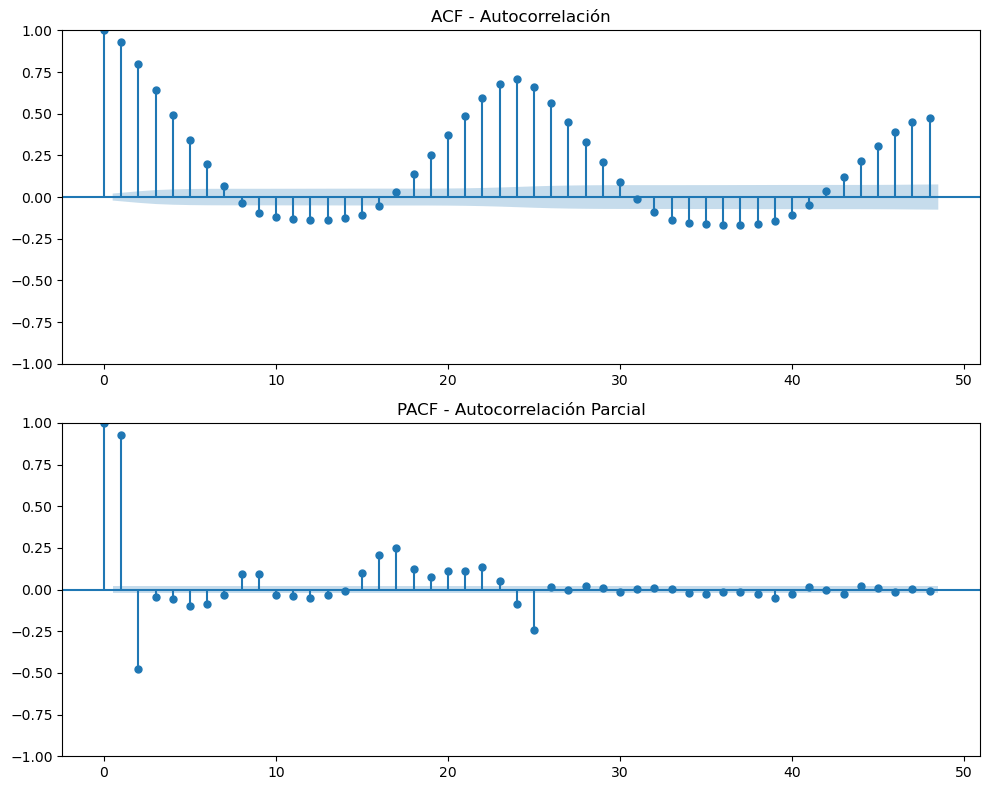

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graficar ACF y PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Función de autocorrelación
plot_acf(building_11a_hourly['kwh'], lags=48, ax=ax[0], title="ACF - Autocorrelación")

# Función de autocorrelación parcial
plot_pacf(building_11a_hourly['kwh'], lags=48, ax=ax[1], title="PACF - Autocorrelación Parcial", method='ywm')

plt.tight_layout()
plt.show()


Análisis de ACF y PACF

ACF: Se observan picos significativos alrededor de los lags múltiplos de 24, lo que confirma la estacionalidad diaria.

PACF: Hay algunos picos significativos en los primeros lags, lo que sugiere un componente autorregresivo (AR) y un orden estacional.

## Forcasting

SARIMA (Seasonal ARIMA): Este modelo es ideal si encontramos estacionalidad y tendencias. La estructura del modelo se adapta a datos con periodicidad, que es común en series de tiempo horarias y diarias.

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar el modelo SARIMA
model = SARIMAX(building_11a_hourly['kwh'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 24))
model_fit = model.fit(disp=False)

# Mostrar el resumen del modelo ajustado
model_summary = model_fit.summary()
model_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                kwh   No. Observations:                 8760
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -45327.550
Date:                            Tue, 07 Jan 2025   AIC                          90665.100
Time:                                    16:58:36   BIC                          90700.489
Sample:                                01-01-2023   HQIC                         90677.158
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8837      0.003    266.059      0.000       0.877       0.890
ma.L1          0.2904      0.006     47.936      0.000       0.278       0.302
ar.S.L24       0.9820      0.001    671.574      0.000       0.979       0.985
ma.S.L24      -0.8565      0.004   -198.968      0.000      -0.865      -0.848
sigma2      1822.4899      9.662    188.625      0.000    1803.553    1841.427
===================================================================================
Ljung-Box (L1) (Q):                   6.18   Jarque-Bera (JB):            104986.55
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                             0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_25056\2079567813.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(pd.date_range(building_11a_hourly.index[-1], periods=forecast_steps+1, freq='H')[1:],


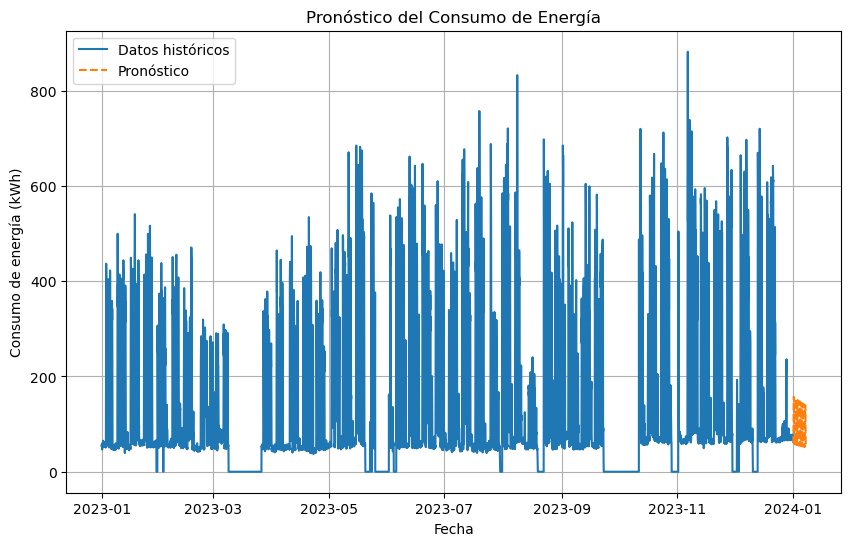

In [13]:
import matplotlib.pyplot as plt

# Realizar pronóstico para las próximas 7 días (7 * 24 horas)
forecast_steps = 7 * 24
forecast = model_fit.forecast(steps=forecast_steps)

# Visualizar el pronóstico
plt.figure(figsize=(10, 6))
plt.plot(building_11a_hourly.index, building_11a_hourly['kwh'], label='Datos históricos')
plt.plot(pd.date_range(building_11a_hourly.index[-1], periods=forecast_steps+1, freq='H')[1:], 
         forecast, label='Pronóstico', linestyle='--')
plt.title('Pronóstico del Consumo de Energía')
plt.xlabel('Fecha')
plt.ylabel('Consumo de energía (kWh)')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import time
# Separar datos para validación (últimos 7 días)
train = building_11a_hourly['kwh'][:-7*24]
test = building_11a_hourly['kwh'][-7*24:]

# Reajustar modelo solo con datos de entrenamiento
model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 24))
model_fit = model.fit(disp=False)

start_time = time.time()
# Realizar pronóstico
forecast = model_fit.forecast(steps=len(test))

# Calcular el tiempo de ejecución
execution_time = time.time() - start_time

# Imprimir el tiempo de ejecución
print(f"Tiempo de ejecución: {execution_time} segundos")

Tiempo de ejecución: 0.015655994415283203 segundos


In [15]:
# Calcular métricas de error
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
smape_score=smape(test, forecast)


print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"sMAPE: {smape_score:.2f}")

MAE: 68.75
RMSE: 104.25
sMAPE: 0.49


In [18]:
forecast

2023-12-25 00:00:00+00:00    66.579102
2023-12-25 01:00:00+00:00    64.624416
2023-12-25 02:00:00+00:00    63.986432
2023-12-25 03:00:00+00:00    62.330843
2023-12-25 04:00:00+00:00    62.320917
                               ...    
2023-12-31 19:00:00+00:00    56.153502
2023-12-31 20:00:00+00:00    52.579701
2023-12-31 21:00:00+00:00    51.022718
2023-12-31 22:00:00+00:00    51.216186
2023-12-31 23:00:00+00:00    50.705831
Freq: h, Name: predicted_mean, Length: 168, dtype: float64

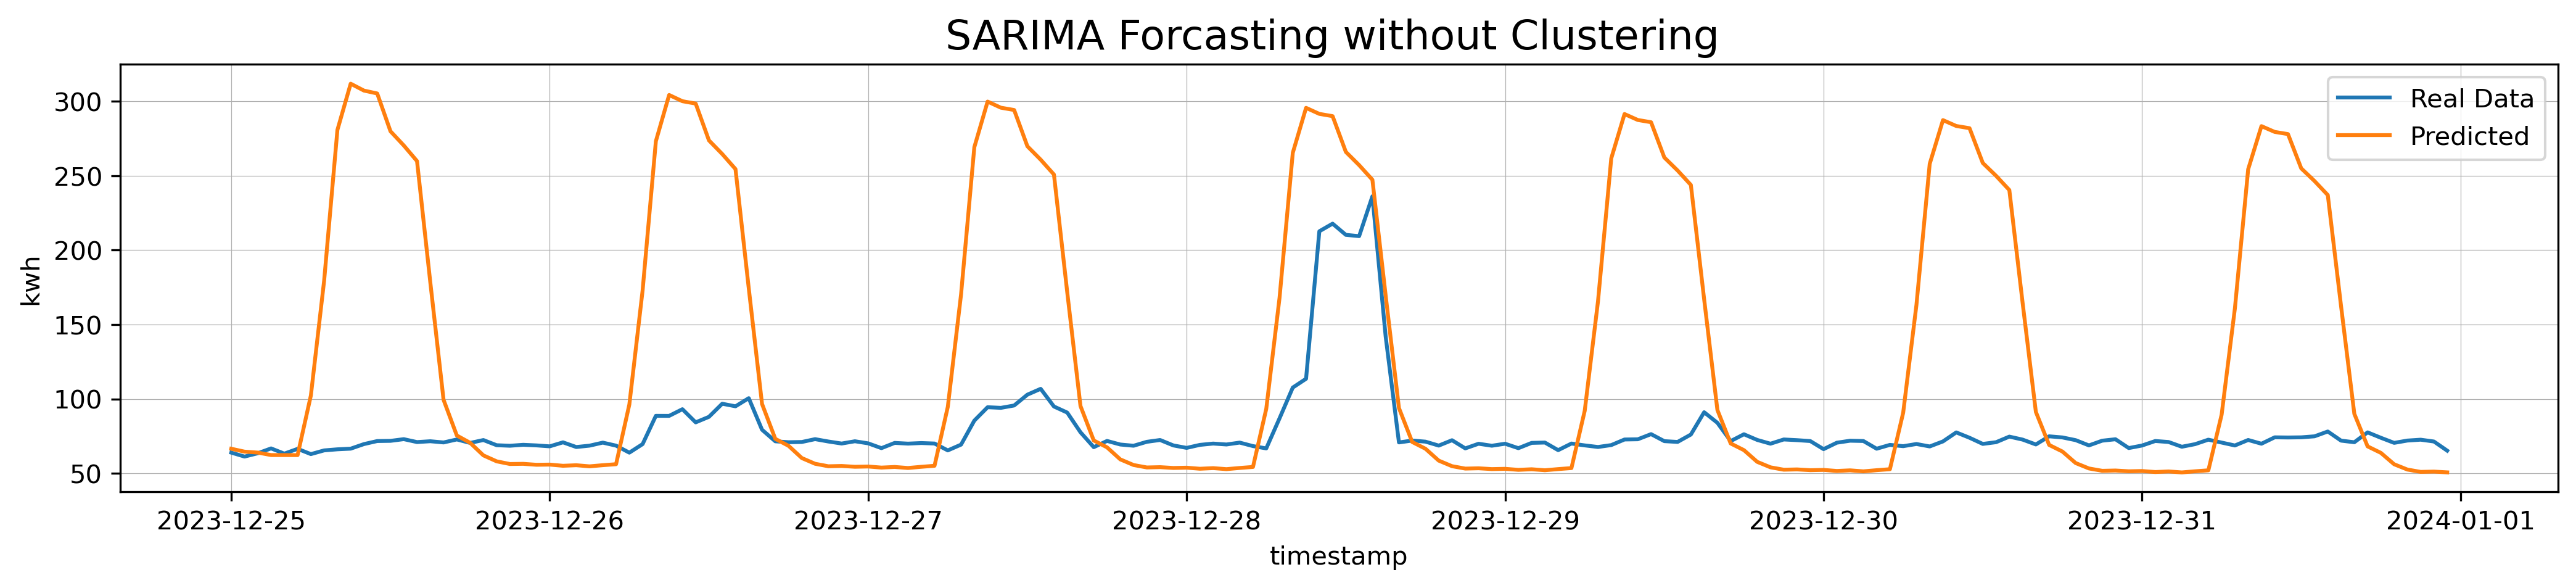

In [22]:
# Graficar el ajuste
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
#plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Real Data')
plt.plot(test.index, forecast, label='Predicted')
plt.grid(linestyle='-', linewidth=0.3)
plt.title('SARIMA Forcasting without Clustering ', fontsize=16)
plt.xlabel('timestamp')
plt.ylabel('kwh')
plt.legend()
plt.grid(linestyle='-', linewidth=0.3)
plt.show()